#모델 학습
이 부분 부터는 colab pro+에서 돌림

5/9-mask detection 파일 참고

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

1) 전처리된 이미지 파일 압축 풀기

In [ ]:
%cd /content/drive/MyDrive/Image_project/Image

In [ ]:
!unzip -qq /content/drive/MyDrive/Image.zip

2)필요한 library import

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

3)다크넷 가져오기

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

4) classNames.names 파일 생성

In [ ]:
f = open('/content/drive/MyDrive/Image_project/category.txt','r')
lines = f.readlines()
f.close() #lines에 class 이름들 들어있음
data = []

count = 0 #첫줄 안가져오는 방법-by 종헌
f = open('/content/drive/MyDrive/darknet/data/ClassNames.names', 'w')
for line in lines: #line -> id name
  if count==0: 
    count+=1
    continue
  temp = line.split('\t')[1].split('\n')[0]+'\n' #name만 갖고온후 \n 해주기->rice만 가져옴
  f.write(temp)
f.close()

5)train, test, validation data 나누기

- train:test:valid = 8:1:1
- 계통추출법을 사용해 5의 배수는 validation으로 10의 배수는 test로 나눔

In [ ]:
#각 이미지 경로 가져오기
import glob
dir = '/content/drive/MyDrive/Image_project/Image'
file_list = glob.glob(dir+'/*.jpg')

In [ ]:
train = []
valid = []
test = []
for i in range(len(file_list)):
  if i %10 ==0: 
    test.append(file_list[i])
  elif i % 5 ==0:
    valid.append(file_list[i])
  else:
    train.append(file_list[i])

6)train,test,validation 경로 적기

In [ ]:
# w 모드로 text 파일을 생성
# test.txt 생성
f = open('/content/drive/MyDrive/darknet/data/train.txt','w')
for t1 in train:
  f.write(t1+'\n')
f.close()

# train.txt 생성
f = open('/content/drive/MyDrive/darknet/data/test.txt','w')
for t1 in test:
  f.write(t1+'\n')
f.close()

# valid.txt 생성
f = open('/content/drive/MyDrive/darknet/data/valid.txt','w')
for t1 in valid:
  f.write(t1+'\n')
f.close()

7)mask_data.data 파일 생성

In [ ]:
t = open('/content/drive/MyDrive/darknet/data/mask_data.data', 'w')
# mask_data.data에 기록
# 클래스 개수 입력
t.write("classes = 100\n")
# mask_data.data train,valid,test 경로입력
t.write("train = /content/drive/MyDrive/darknet/data/train.txt\n")
t.write("test = /content/drive/MyDrive/darknet/data/test.txt\n")
t.write("valid = /content/drive/MyDrive/darknet/data/valid.txt\n")

# class 이름 값 기록
t.write("names = /content/drive/MyDrive/darknet/data/ClassNames.names\n")
t.write("backup = /content/drive/MyDrive/darknet/backup/")
t.close()

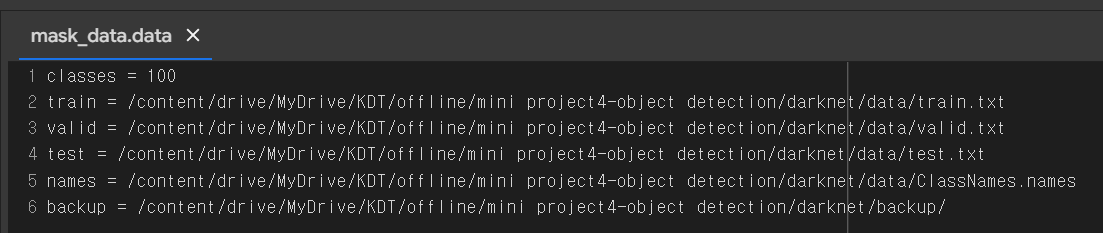

8)pre-trained 된 weight값 가져오기

In [ ]:
%cd '/content/drive/MyDrive/darknet'

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

9)yolov4-custom.cfg파일 수정 

✨net layer
* subdivision = 16 -> batch size를 더 쪼개서 16개로 한다는 의미
* width = 416
* height = 416
* max_batches = num_classes * 2000 = 100 * 2000 = 200000
* steps = max_batches * 0.8, max_batches * 0.9 = 3200, 3600 -> 160000, 180000

✨yolo 바로 앞 conv layer
* filters = 315로
* yolo layer 앞에 있는 convolutional layer 마다 filers = (num_classes + 5) * 3 = 315

✨yolo layer(=classification layer)
* yolo layer 마다 classes=100


10)makefile 파일 수정 후 make로 compile

darknet 폴더내에 있는 makefile에는 darknet구축을 위한 옵션이 저장되어있음

In [ ]:
# GPU, OPENCV, LIBSO true
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile #활성화 시켜주는 것
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile #gpu 돌릴때 가속화 시킬때 사용
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

* OpenCV는 오픈 소스 컴퓨터 비전 라이브러리이다. 
* Libso는 so 라이브러리 파일(=동적 라이브러리 파일)을 만드는 옵션이다. LIBSO=1(=True)로 설정하면 darknet.so 파일이 생성되며, 파이썬으로 darknet을 작동시키는 것이 가능해진다.

In [ ]:
# 위의 변경된 옵션으로 makefile을 컴파일하면 darknet.py 사용이 가능해진다.
!make

11)darknet으로 모델학습

custom dataset으로 transfer learning

In [ ]:
# 모델학습
!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg /content/drive/MyDrive/darknet/yolov4.conv.137 -dont_show -map

In [ ]:
# 모델학습재개하는법(최근 100번째단위 weight로)
#!./darknet detector train data/mask_data.data cfg/yolov4-custom.cfg /content/drive/MyDrive/darknet/backup/yolov4-custom_last.weights -dont_show -map